<a href="https://colab.research.google.com/github/Jmmostafa/VaRBacktestingEngine/blob/main/01_Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
# import statsmodels.api as sm

## Extracting Sample Data

In [3]:
symbols = ['^GSPC', 'GC=F', '^TNX','EURUSD=X']
df = yf.download(symbols, start = '2020-01-01', auto_adjust=True)['Close'].dropna()
df.columns = ['EURUSD', 'GOLD', 'GSPC', '10Y']
df['10Y'] = df['10Y']/100
df.tail()

[*********************100%***********************]  4 of 4 completed


,EURUSD,GOLD,GSPC,10Y
Date,,,,
2025-12-10,1.162831,4196.399902,6886.680176,0.04164
2025-12-11,1.170124,4285.500000,6901.000000,0.04141
2025-12-12,1.173943,4300.100098,6827.410156,0.04194
2025-12-15,1.173764,4306.700195,6816.509766,0.04182
2025-12-16,1.175461,4353.100098,6800.259766,0.04149


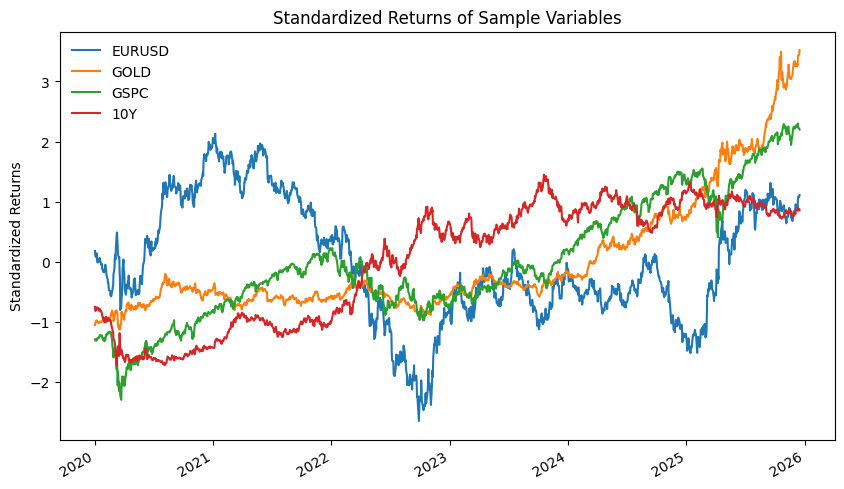

In [4]:
# standardizing the variables for comparison
df_standardized = (df - df.mean())/df.std()
df_standardized.plot(figsize=(10, 6))
plt.xlabel('')
plt.ylabel('Standardized Returns')
plt.title('Standardized Returns of Sample Variables')
plt.legend(frameon = False)
plt.show()

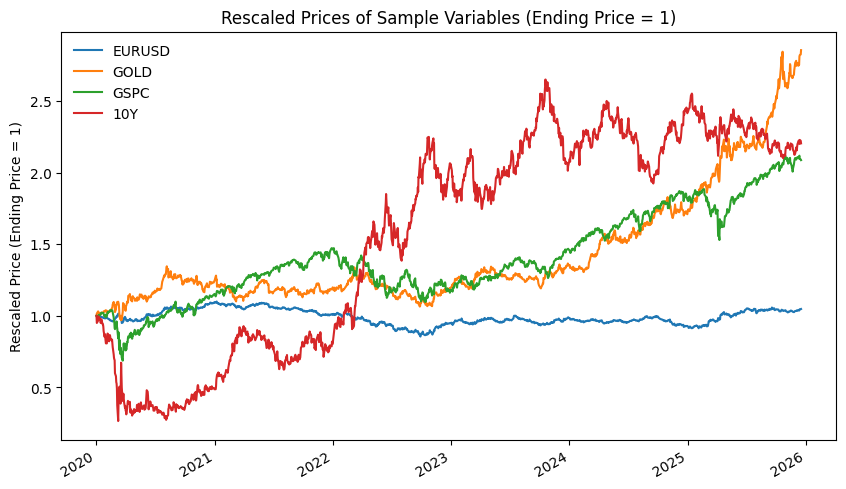

In [5]:
# rescaleding the data for visualization
df_rescaled = df / df.iloc[0]

df_rescaled.plot(figsize=(10, 6))
plt.xlabel('')
plt.ylabel('Rescaled Price (Ending Price = 1)')
plt.title('Rescaled Prices of Sample Variables (Ending Price = 1)')
plt.legend(frameon = False)
plt.grid(False)
plt.show()

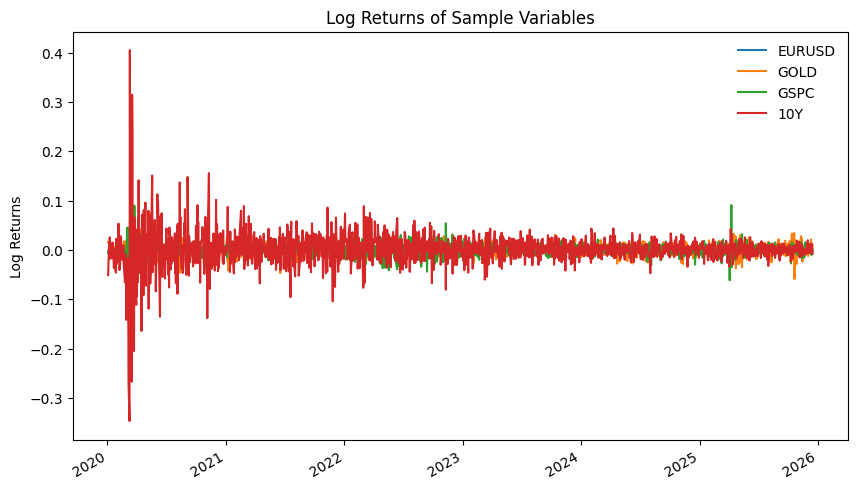

In [6]:
# calculating log returns
df_returns = np.log(df/(df.shift(1))).dropna()
df_returns.plot(figsize=(10, 6))
plt.xlabel('')
plt.ylabel('Log Returns')
plt.title('Log Returns of Sample Variables')
plt.legend(frameon = False)
plt.show()

# Exploratory Analysis

In [7]:
# Descriptive statistics
all_stats_data = {}
for column in df_returns.columns:
  stats_data = {
      'Count': df_returns[column].count(),
      'Mean': df_returns[column].mean(),
      'Median': df_returns[column].median(),
      'Std Dev': df_returns[column].std(),
      'Skew': df_returns[column].skew(),
      'Kurt': df_returns[column].kurt(),
      'Min': df_returns[column].min(),
      'Max': df_returns[column].max(),
      '1% quantile': df_returns[column].quantile(0.01),
      '99% quantile': df_returns[column].quantile(0.99)
  }
  all_stats_data[column] = stats_data
df_stats = pd.DataFrame(all_stats_data)
df_stats.T

,Count,Mean,Median,Std Dev,Skew,Kurt,Min,Max,1% quantile,99% quantile
EURUSD,1496.0,0.000031,-0.000068,0.004795,0.027143,2.238246,-0.028144,0.027537,-0.012398,0.012671
GOLD,1496.0,0.000701,0.000991,0.010717,-0.366205,3.338104,-0.059062,0.057775,-0.028284,0.027468
GSPC,1496.0,0.000492,0.000963,0.013230,-0.648543,14.752077,-0.127652,0.090895,-0.036334,0.030143
10Y,1496.0,0.000528,0.000473,0.035658,0.256153,28.526186,-0.347009,0.404797,-0.094665,0.088899


In [8]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd

# Initialize dictionaries to store results
new_stats = {
    'ADF Statistic': {},
    'ADF p-value': {},
    'Ljung-Box Q-stat (lag 10)': {},
    'Ljung-Box p-value (lag 10)': {}
}

for column in df_returns.columns:
    # Augmented Dickey-Fuler Test for Stationarity
    adf_result = adfuller(df_returns[column])
    new_stats['ADF Statistic'][column] = adf_result[0]
    new_stats['ADF p-value'][column] = adf_result[1]

    # Ljung-Box Test for autocorrelation at lag 10
    # Using return_df=True to get a DataFrame result, then select the row for lag 10
    lb_test_results = acorr_ljungbox(df_returns[column], lags=[10], return_df=True)
    new_stats['Ljung-Box Q-stat (lag 10)'][column] = lb_test_results.loc[10, 'lb_stat']
    new_stats['Ljung-Box p-value (lag 10)'][column] = lb_test_results.loc[10, 'lb_pvalue']

# Convert the dictionary of new_stats into a DataFrame
df_new_tests = pd.DataFrame(new_stats)

# Transpose df_new_tests to match the orientation of df_stats (stats as rows, assets as columns)
df_new_tests_transposed = df_new_tests.T

# Concatenate these new statistics to the existing df_stats
df_stats = pd.concat([df_stats, df_new_tests_transposed])
df_stats.T

,Count,Mean,Median,Std Dev,Skew,Kurt,Min,Max,1% quantile,99% quantile,ADF Statistic,ADF p-value,Ljung-Box Q-stat (lag 10),Ljung-Box p-value (lag 10)
EURUSD,1496.0,0.000031,-0.000068,0.004795,0.027143,2.238246,-0.028144,0.027537,-0.012398,0.012671,-37.501430,0.000000e+00,13.091998,2.185735e-01
GOLD,1496.0,0.000701,0.000991,0.010717,-0.366205,3.338104,-0.059062,0.057775,-0.028284,0.027468,-16.766981,1.296239e-29,16.626234,8.305452e-02
GSPC,1496.0,0.000492,0.000963,0.013230,-0.648543,14.752077,-0.127652,0.090895,-0.036334,0.030143,-11.887370,5.979448e-22,235.915845,4.932574e-45
10Y,1496.0,0.000528,0.000473,0.035658,0.256153,28.526186,-0.347009,0.404797,-0.094665,0.088899,-6.599482,6.792574e-09,132.133680,1.713747e-23


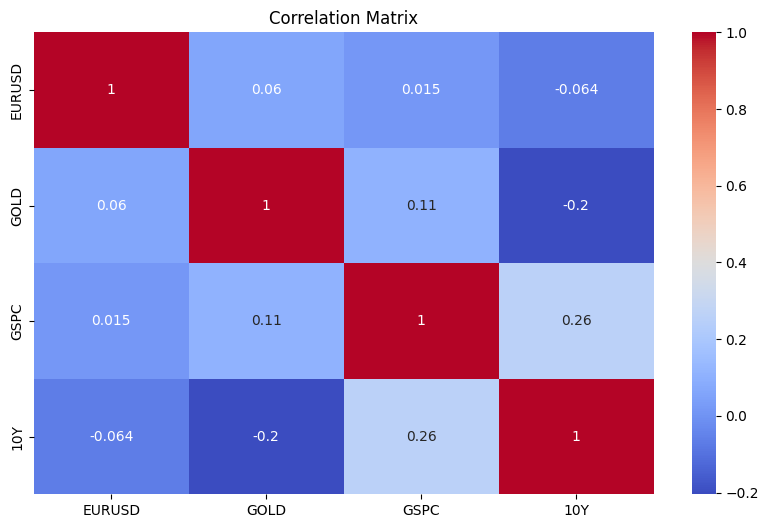

In [9]:
# Correlation Matrix
df_corr = df_returns.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(df_corr, annot = True, cmap = 'coolwarm')
plt.title('Correlation Matrix')
plt.show()

[*********************100%***********************]  4 of 4 completed


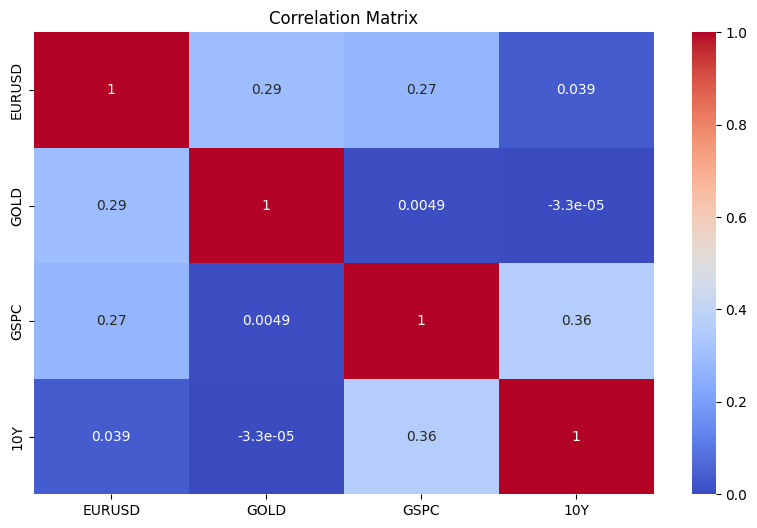

In [10]:
# correlations accross the stressed periods

symbols = ['^GSPC', 'GC=F', '^TNX','EURUSD=X']
df_stressed = yf.download(symbols, start = '2007-01-01', end = '2009-12-31', auto_adjust=True)['Close'].dropna()
df_stressed.columns = ['EURUSD', 'GOLD', 'GSPC', '10Y']
df_stressed['10Y'] = df_stressed['10Y']/100

# Stressed Periods Correlations
df_stressed_returns = np.log(df_stressed/(df_stressed.shift(1))).dropna()
df_stressed_corr = df_stressed_returns.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(df_stressed_corr, annot = True, cmap = 'coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [11]:
# Calculating VaR and ES

In [12]:
def calculate_var_es(returns, confidence_level=0.95):
    """
    Calculates historical VaR and ES for a given series of returns.
    Args:
        returns (pd.Series): Series of asset returns.
        confidence_level (float): Confidence level (e.g., 0.95 for 95%).
    Returns:
        tuple: (VaR, ES)
    """
    # Sort returns in ascending order
    sorted_returns = returns.sort_values(ascending=True)

    # Calculate VaR (negative of the quantile at the specified confidence level)
    # For a 95% confidence level, we look at the 5th percentile for losses.
    # Since returns are sorted ascending, this is returns.quantile(1 - confidence_level)
    var = sorted_returns.quantile(1 - confidence_level)

    # Calculate ES (average of returns below VaR)
    es = sorted_returns[sorted_returns <= var].mean()

    return var, es


print("\n--- Value at Risk (VaR) and Expected Shortfall (ES) ---")
risk_metrics = {}

confidence_levels = [0.95, 0.99]

for column in df_returns.columns:
    risk_metrics[column] = {}
    for level in confidence_levels:
        var, es = calculate_var_es(df_returns[column], level)
        risk_metrics[column][f'VaR ({int(level*100)}%)'] = var
        risk_metrics[column][f'ES ({int(level*100)}%)'] = es

# Convert the dictionary to a DataFrame for better presentation
df_risk_metrics = pd.DataFrame(risk_metrics)
display(df_risk_metrics.T)


--- Value at Risk (VaR) and Expected Shortfall (ES) ---


,VaR (95%),ES (95%),VaR (99%),ES (99%)
EURUSD,-0.007389,-0.010445,-0.012398,-0.015622
GOLD,-0.017160,-0.025371,-0.028284,-0.039892
GSPC,-0.018554,-0.032282,-0.036334,-0.058565
10Y,-0.043915,-0.080712,-0.094665,-0.167013
